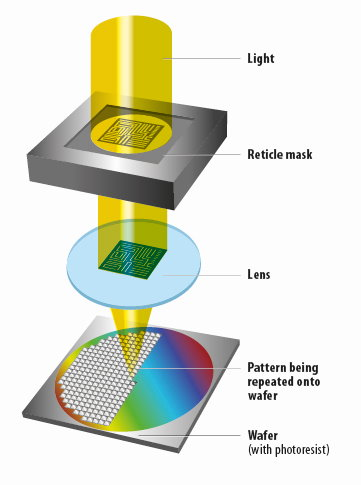

## Task: image(Ideal Pattern)-to-image(Optimized Mask) translation by using UNet model

#### Predicting the optimized intensity (or presence/absence) of each pixel in the mask. This makes the task more akin to regression or direct pixel-wise transformation, where each pixel's output is a continuous value representing its optimized state.

In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms, Resize
import torch.nn as nn
import torchvision.transforms.functional as F
from torch.optim.lr_scheduler import StepLR

class LithographyDataset(Dataset):
    def __init__(self, pattern_dir, mask_dir, transform=None):
        self.pattern_dir = pattern_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.patterns = [x for x in os.listdir(pattern_dir) if x.endswith('.png') or x.endswith('.jpg')]
        self.pattern_to_mask = {x: x.replace('.png', 'OPC.png').replace('.jpg', 'OPC.jpg') for x in self.patterns}

    def __len__(self):
        return len(self.patterns)

    def __getitem__(self, idx):
        pattern_filename = self.patterns[idx]
        mask_filename = self.pattern_to_mask[pattern_filename]
        pattern_path = os.path.join(self.pattern_dir, pattern_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        pattern = Image.open(pattern_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            pattern, mask = self.transform(pattern, mask)

        return pattern, mask

def get_transforms(augment=False):
    def transform(pattern, mask):
        if augment:
            # Apply augmentations
            # Resize
            resize = Resize((260, 260))
            pattern = resize(pattern)
            mask = resize(mask)

            # Random crop
            i, j, h, w = transforms.RandomResizedCrop.get_params(
                pattern, scale=(0.8, 1.0), ratio=(0.75, 1.33))
            pattern = F.crop(pattern, i, j, h, w)
            mask = F.crop(mask, i, j, h, w)

            # Random horizontal flipping
            if torch.rand(1) < 0.5:
                pattern = F.hflip(pattern)
                mask = F.hflip(mask)

            # Random vertical flipping
            if torch.rand(1) < 0.5:
                pattern = F.vflip(pattern)
                mask = F.vflip(mask)

            # Random rotation
            angle = transforms.RandomRotation.get_params(degrees=(-15, 15))
            pattern = F.rotate(pattern, angle)
            mask = F.rotate(mask, angle)

            # Random affine
            params = transforms.RandomAffine.get_params(
                degrees=(-10, 10), translate=(0.1, 0.1), scale_ranges=(0.9, 1.1), shears=None, img_size=pattern.size)
            pattern = F.affine(pattern, *params, interpolation=F.InterpolationMode.NEAREST, fill=0)
            mask = F.affine(mask, *params, interpolation=F.InterpolationMode.NEAREST, fill=0)

        # Always apply
        resize = Resize((256, 256))
        pattern = resize(pattern)
        mask = resize(mask)
        pattern = F.to_tensor(pattern)
        mask = F.to_tensor(mask)
        return pattern, mask

    return transform

# Paths to your data
pattern_dir = 'ganopc-data/target/images'
mask_dir = 'ganopc-data/mask/images'

# Initialize the dataset
full_dataset = LithographyDataset(pattern_dir, mask_dir)

# Split dataset into training, validation, and testing sets
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_test_size = total_size - train_size
train_dataset, val_test_dataset = random_split(full_dataset, [train_size, val_test_size])
val_size = int(0.5 * val_test_size) 
test_size = val_test_size - val_size
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Apply transformations
train_dataset.dataset.transform = get_transforms(augment=False)
val_dataset.dataset.transform = get_transforms(augment=False)
test_dataset.dataset.transform = get_transforms(augment=False)

# Creating DataLoaders for each set
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

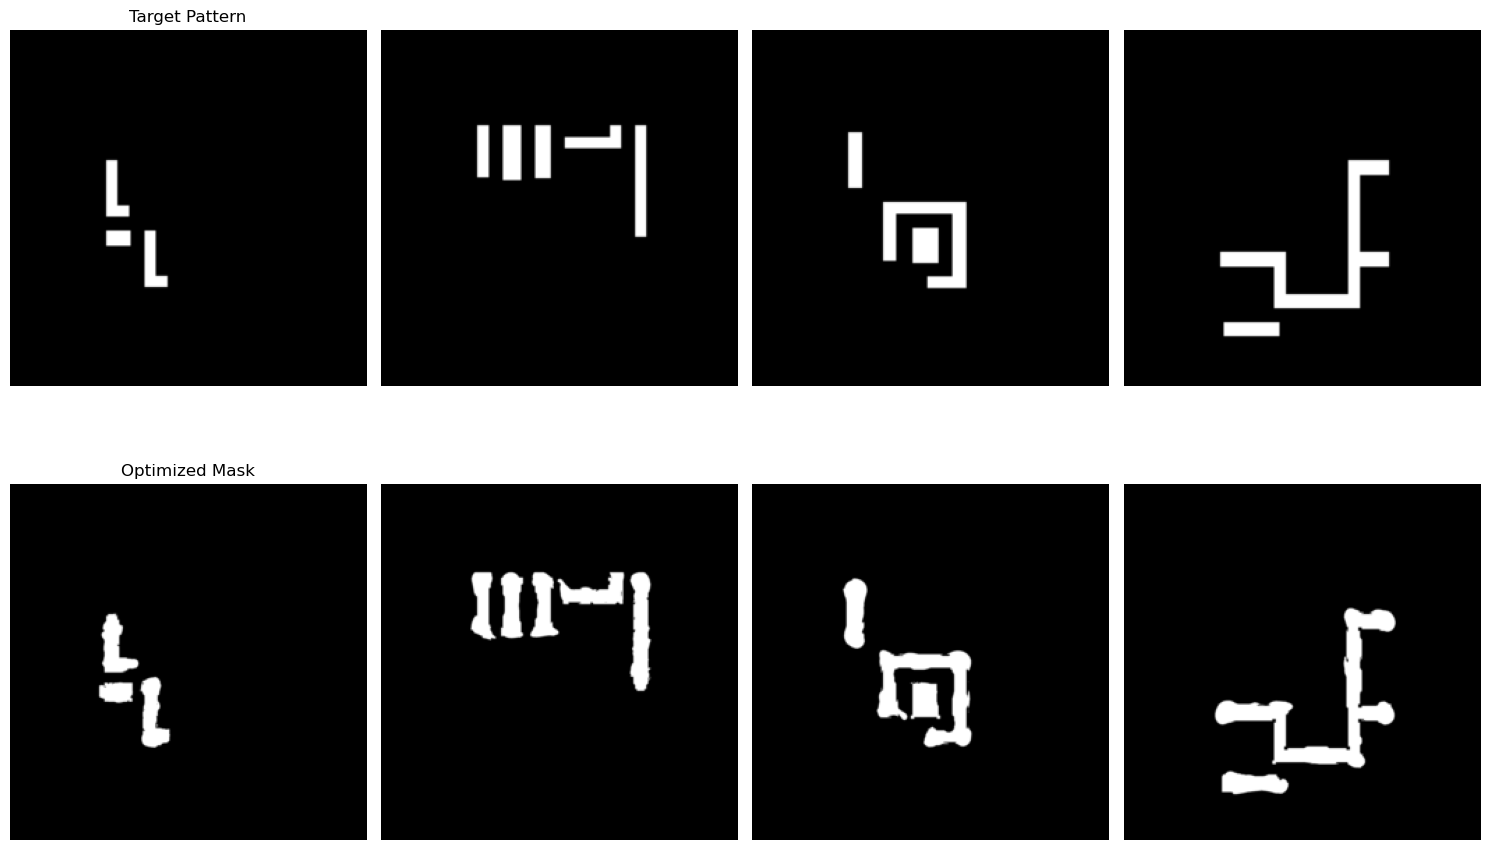

In [2]:
def plot_images_grid(images, titles, n_rows=2, n_cols=4, figsize=(15, 10)):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axs[i, j]
            if i < len(images) and j < len(images[i]):
                # Squeeze to remove singleton dimensions and convert to numpy
                img = images[i][j].squeeze().numpy()
                
                if img.ndim == 2:  # Grayscale image
                    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
                else:  # RGB image
                    ax.imshow(img.transpose((1, 2, 0)))
                
                if j == 0:
                    ax.set_title(titles[i])
                ax.axis('off')
            else:
                ax.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_batch(dataloader):
    dataiter = iter(dataloader)
    targets, masks = next(dataiter)
    n_display = min(4, len(targets))
    images_to_plot = [targets[:n_display], masks[:n_display]]
    titles = ['Target Pattern', 'Optimized Mask']
    plot_images_grid(images_to_plot, titles, n_rows=2, n_cols=n_display)

visualize_batch(train_loader)

Pattern - Min pixel value: 0.0
Pattern - Max pixel value: 1.0
Mask - Min pixel value: 0.0
Mask - Max pixel value: 1.0


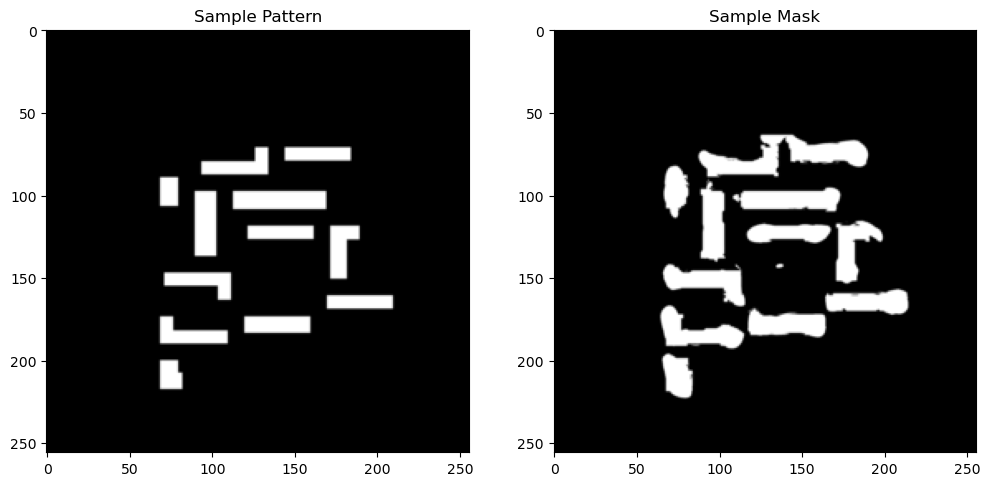

In [3]:
def check_normalization(data_loader):
    for patterns, masks in data_loader:
        pattern = patterns[0]
        mask = masks[0]
        
        print("Pattern - Min pixel value:", pattern.min().item())
        print("Pattern - Max pixel value:", pattern.max().item())
        print("Mask - Min pixel value:", mask.min().item())
        print("Mask - Max pixel value:", mask.max().item())
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(pattern.squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Sample Pattern")
        plt.subplot(1, 2, 2)
        plt.imshow(mask.squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Sample Mask")
        plt.show()

        break

check_normalization(train_loader)

In [4]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Input is CHW. For padding, calculate the difference of x1 and x2 dimensions.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        self.final_activation = nn.Sigmoid()  # output values are in [0, 1]
        #self.final_activation = nn.Tanh()  # Only if your output values are in [-1, 1]

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.final_activation(logits)

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        running_loss_train = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() * inputs.size(0)

        train_loss = running_loss_train / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        running_loss_val = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * inputs.size(0)

        val_loss = running_loss_val / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered. Stopping training.')
                break

        scheduler.step()  # Update the learning rate

    model.load_state_dict(best_model_wts)
    return train_losses, val_losses

In [6]:
def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2)
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Epoch 1/20, Train Loss: 0.0524, Validation Loss: 0.0264
Epoch 2/20, Train Loss: 0.0171, Validation Loss: 0.0110
Epoch 3/20, Train Loss: 0.0085, Validation Loss: 0.0065
Epoch 4/20, Train Loss: 0.0055, Validation Loss: 0.0048
Epoch 5/20, Train Loss: 0.0041, Validation Loss: 0.0039
Epoch 6/20, Train Loss: 0.0034, Validation Loss: 0.0037
Epoch 7/20, Train Loss: 0.0029, Validation Loss: 0.0028
Epoch 8/20, Train Loss: 0.0027, Validation Loss: 0.0027
Epoch 9/20, Train Loss: 0.0024, Validation Loss: 0.0027
Epoch 10/20, Train Loss: 0.0023, Validation Loss: 0.0024
Epoch 11/20, Train Loss: 0.0019, Validation Loss: 0.0023
Epoch 12/20, Train Loss: 0.0018, Validation Loss: 0.0022
Epoch 13/20, Train Loss: 0.0017, Validation Loss: 0.0022
Epoch 14/20, Train Loss: 0.0017, Validation Loss: 0.0022
Epoch 15/20, Train Loss: 0.0016, Validation Loss: 0.0022
Epoch 16/20, Train Loss: 0.0015, Validation Loss: 0.0022
Epoch 17/20, Train Loss: 0.0015, Validation Loss: 0.0022
Epoch 18/20, Train Loss: 0.0014, Validat

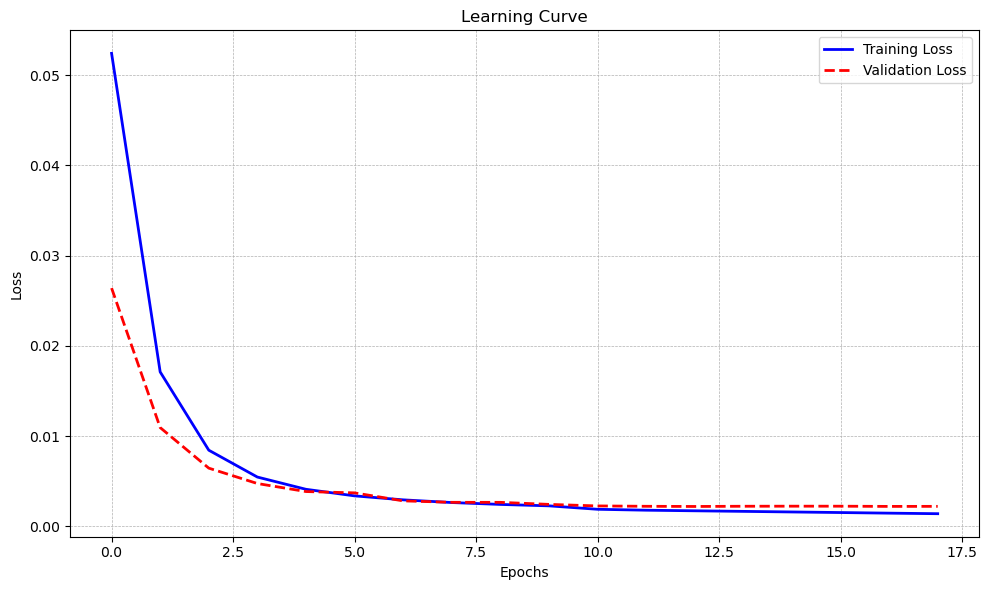

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=1).to(device)
criterion = nn.MSELoss() # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5)


# Plot the learning curve
plot_learning_curve(train_losses, val_losses)

In [8]:
model_path = 'unet_lithography_model.pth'
torch.save(model.state_dict(), model_path)

In [9]:
def evaluate_model(model, test_loader, criterion):
    model.eval() 
    total_loss = 0.0
    device = next(model.parameters()).device
    
    with torch.no_grad():  # No need to track gradients for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
    
    print(f'Test Loss (L2 Metric): {total_loss / len(test_loader.dataset):.4f}')

evaluate_model(model, test_loader, nn.MSELoss())

Test Loss (L2 Metric): 0.0022


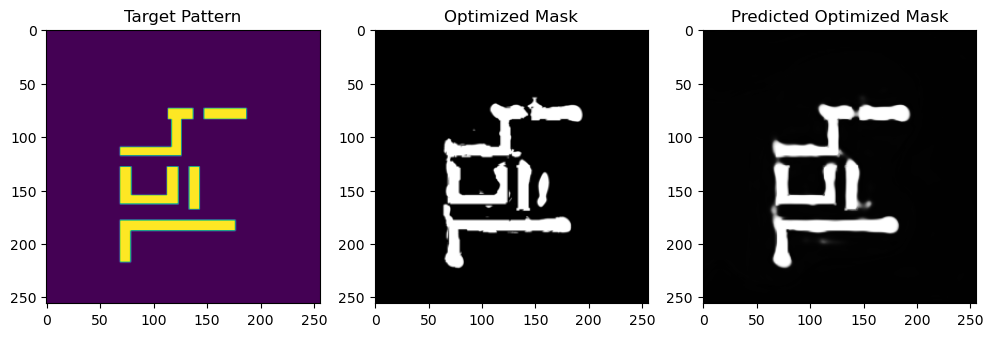

In [16]:
def compare_masks(model, dataset, num_samples, device='cuda'):
    model.to(device)
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        pattern, real_mask = dataset[idx]
        pattern = pattern.unsqueeze(0).to(device)  # Add batch dimension
        real_mask = real_mask.to(device)
        
        with torch.no_grad():
            optimized_mask = model(pattern)

        pattern = pattern.squeeze(0).cpu()  # Remove batch dimension and move to CPU for plotting
        optimized_mask = optimized_mask.squeeze(0).cpu()
        real_mask = real_mask.cpu()

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(pattern.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[0].set_title(f'Target Pattern')
        axes[1].imshow(real_mask.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        axes[1].set_title(f'Optimized Mask')
        axes[2].imshow(optimized_mask.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        axes[2].set_title(f'Predicted Optimized Mask')
        plt.savefig("optimized_mask_comparison.png", dpi=300)
        plt.show()

compare_masks(model, test_dataset, num_samples=1, device='cuda')